In [1]:
import matplotlib.pyplot as plt
import numpy as np
from opensees import uniaxial

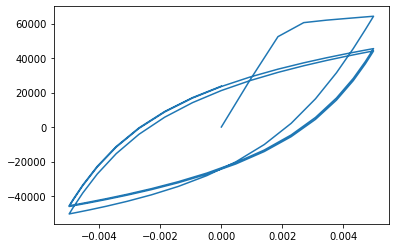

In [2]:
strain = 0.005*np.sin(np.linspace(0, 6*np.pi, 100))


with uniaxial.Steel02(1, 60e3, 29e6, 0.05, 10.) as steel:
    
    stress = [steel.getStress(e, commit=True) for e in strain]


plt.plot(strain, stress);



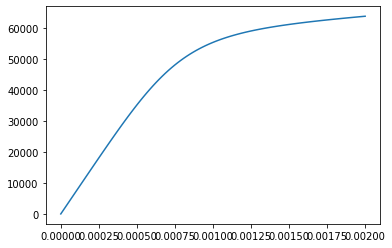

In [3]:
stress = []
with uniaxial.Steel02(1, 60e3, 29e6, 0.05, 4.) as steel:
    for e in np.linspace(0, 0.005, 100):
        steel.setTrialStrain(e)
        s = steel.getStress()
        steel.commitState()
        stress.append(s)

plt.plot(np.linspace(0, 0.002, 100), stress)

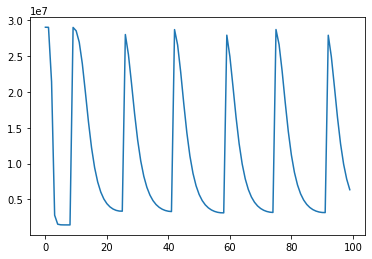

In [ ]:
tangent = []

with uniaxial.Steel02(1, 60e3, 29e6, 0.05, 10.) as steel:
    for e in strain:
        steel.setTrialStrain(e)
        tangent.append(steel.getTangent())
        steel.commitState()

plt.plot(tangent)

In [ ]:
from math import sqrt
from opensees.units.english import ksi, psi, inch, ft
# nominal concrete compressive strength
fc = -4.0*ksi              # CONCRETE Compressive Strength ksi   (+Tension -Compression)
Ec = 57*ksi*sqrt(-fc/psi)  # Concrete Elastic Modulus
# unconfined concrete
fc1U = fc                  # UNCONFINED concrete (todeschini parabolic model) maximum stress
eps1U = -0.003             # strain at maximum strength of unconfined concrete
fc2U = 0.2*fc1U            # ultimate stress
eps2U = -0.01              # strain at ultimate stress
_lambda = 0.1              # ratio between unloading slope at eps2 and initial slope Ec
# tensile-strength properties
ftU = -0.14*fc1U           # tensile strength +tension
Ets = ftU/0.002            # tension softening stiffness
# -----------
Fy = 66.8*ksi              # STEEL yield stress
Es = 29000.*ksi            # modulus of steel
Bs = 0.005                 # strain-hardening ratio 
R0 = 18                    # control the transition from elastic to plastic branches
cR1 = 0.925                # control the transition from elastic to plastic branches
cR2 = 0.15                 # control the transition from elastic to plastic branches

In [ ]:
concU = uniaxial.Concrete02(1, fc1U, eps1U, fc2U, eps2U, _lambda, ftU, Ets)      # build cover, concrete (unconfined)
reinf = uniaxial.Steel02(None, Fy, Es, Bs, R0, cR1, cR2)                            # build 'reinforcement material

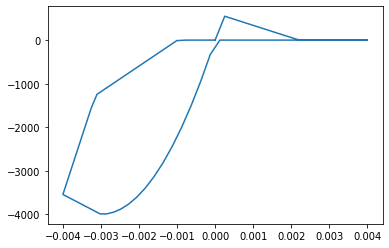

In [ ]:
strain = 0.004*np.sin(np.linspace(0, 2*np.pi, 100))

with concU as c:
    stress = [c.getStress(e, commit=True) for e in strain]

plt.plot(strain, stress)

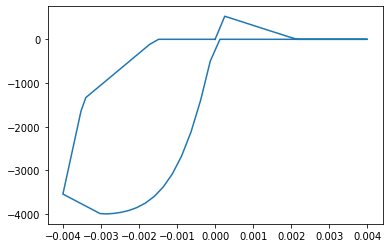

In [ ]:
with uniaxial.Concrete02IS(1, 4e3*ksi, fc1U, eps1U, fc2U, eps2U, [_lambda, ftU, Ets]) as conc:
    plt.plot(strain, [conc.getStress(e, commit=True) for e in strain])

In [11]:
with uniaxial.Concrete04(1, fc1U, eps1U, eps2U, 4e3*ksi) as conc:
    plt.plot(strain, [conc.getStress(e, commit=True) for e in strain])

WARNING could not create uniaxialMaterial Concrete04
ERROR: 


IndexError: _Map_base::at